In [5]:
#importing all necessary Libraries
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input


In [6]:
!pip install opencv-python

In [32]:
import os
import cv2

def load_images_from_folder(foldername):
    images = []
    for filename in os.listdir(foldername):
        img = cv2.imread(os.path.join(foldername, filename))
        if img is not None:
            images.append(img)
    return images

img_list = load_images_from_folder("C:\\Users\\tangu\\Downloads\\mini\\TRAINING_CG-1050\\TRAINING\\ORIGINAL")



In [33]:
len(img_list[0])

199

In [35]:
data_dir = r'C:\\Users\\tangu\\Downloads\\mini\\TRAINING_CG-1050\\TRAINING\\ORIGINAL'
train_dir = os.path.join(data_dir, 'train')


In [36]:
#class Labels
image_type = ['Authenticated','Tampered']


In [37]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file.jpg'
    ela_filename = 'temp_ela_file.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality=quality)
    
    temp_image = Image.open(temp_filename)
    ela_image = ImageChops.difference(image, temp_image)
    extrema = ela_image.getextrema()
    
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    
    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image




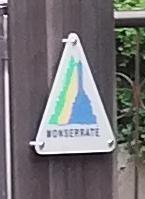

In [38]:
real_image_path = "C:\\Users\\tangu\\Downloads\\mini\\TRAINING_CG-1050\\TRAINING\\ORIGINAL\\authenticated.jpg" 
Image.open(real_image_path)

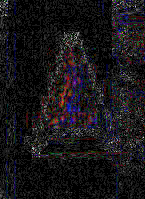

In [45]:
from IPython.display import display

real_image_path = "C:\\Users\\tangu\\Downloads\\mini\\TRAINING_CG-1050\\TRAINING\\ORIGINAL\\authenticated.jpg"
ela_image = convert_to_ela_image(real_image_path, 85)
display(ela_image)  # Display the ELA image


In [46]:
image_size = (128, 128)

def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 85).resize(image_size)).flatten()


In [41]:
X = []  # ELA converted images
Y = []  # Labels (0 for fake, 1 for real)

In [96]:
import random
import os

# Set up variables for authenticated images
X_auth = []
Y_auth = []

# Specify path to authenticated images
auth_path = 'C:\\Users\\tangu\\Downloads\\mini\\TRAINING_CG-1050\\TRAINING\\ORIGINAL'

# Loop through authenticated files and process images
for dirname, _, filenames in os.walk(auth_path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            ela_image = prepare_image(full_path)  # Use the prepare_image function you defined
            X_auth.append(ela_image)
            Y_auth.append(1)  # Label: 1 for authentic images

# Set up variables for tampered images
X_tamp = []
Y_tamp = []

# Specify path to tampered images
tamp_path = 'C:\\Users\\tangu\\Downloads\\mini\\TRAINING_CG-1050\\TRAINING\\TAMPERED'

# Loop through tampered files and process images
count = 0
for dirname, _, filenames in os.walk(tamp_path):
    for filename in filenames:
        # count += 1
        # if count < 1eee:
        #     pass
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            ela_image = prepare_image(full_path)  # Use the prepare_image function you defined
            X_tamp.append(ela_image)
            Y_tamp.append(0)  # Label: 0 for tampered images
            
            # Print processing status
            if len(Y_tamp) % 4000 == 0:
                print(f'Processing {len(Y_tamp)} tampered images')

# Combine authenticated and tampered data
X = X_auth + X_tamp
Y = Y_auth + Y_tamp

# Shuffle data
combined_data = list(zip(X, Y))
random.shuffle(combined_data)
X, Y = zip(*combined_data)

# Print number of images processed
print(len(X), len(Y))


1460 1460


In [97]:
au, tp = 0, 0

for label in Y:
    if label == 0:
        au += 1
    else:
        tp += 1

print("Tampered Images (tp):", tp)
print("Authentic Images (au):", au)


Tampered Images (tp): 730
Authentic Images (au): 730


In [99]:
from keras.utils import to_categorical


In [102]:
from sklearn.utils import shuffle

for i in range(10):
    X, Y = shuffle(X, Y, random_state=i)  # Use the current value of "i" as the random seed


In [103]:
#reshaping the image array
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)


In [106]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=4)

# Reshaping the input data for compatibility with Convolutional Neural Networks
X_train = X_train.reshape(-1, 128, 128, 3)
X_val = X_val.reshape(-1, 128, 128, 3)


print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))


1168 1168
292 292


In [107]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense

def build_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='valid', activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    return model

model = build_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 62, 62, 32)        0         
                                                                 
 flatten (Flatten)           (None, 123008)            0         
                                                                 
 dense (Dense)               (None, 256)               31490304  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [109]:
model = build_model()

# Save the model summary to a text file
with open('model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

# Print a message indicating the summary is saved
print("Model summary saved to 'model_summary.txt'")


Model summary saved to 'model_summary.txt'


In [110]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

def build_model():
    model = Sequential()

    model.add(Conv2D(input_shape=(128, 128, 3), filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(units=512, activation="relu"))
    model.add(Dense(units=256, activation="relu"))
    model.add(Dense(units=2, activation="softmax"))

    return model

model = build_model()
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 conv2d_16 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                 

In [111]:
from tensorflow.keras.optimizers import Adam

In [114]:
from keras.optimizers import Adam

init_lr = 1e-4
optimizer = Adam(learning_rate=init_lr)


In [116]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [118]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [119]:
# Training the model
batch_size = 32
epochs = 10

history = model.fit(
    X_train, Y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, Y_val),
    verbose=2
)

# score = model.evaluate(x_test, y_test)
# print('Test accuracy:', score[1])


Epoch 1/10
37/37 - 700s - loss: 0.8146 - accuracy: 0.5291 - val_loss: 0.6703 - val_accuracy: 0.5856 - 700s/epoch - 19s/step
Epoch 2/10
37/37 - 287s - loss: 0.6530 - accuracy: 0.6207 - val_loss: 0.6534 - val_accuracy: 0.5993 - 287s/epoch - 8s/step
Epoch 3/10
37/37 - 1044s - loss: 0.6281 - accuracy: 0.6378 - val_loss: 0.7667 - val_accuracy: 0.6062 - 1044s/epoch - 28s/step
Epoch 4/10
37/37 - 252s - loss: 0.6196 - accuracy: 0.6764 - val_loss: 0.8788 - val_accuracy: 0.6062 - 252s/epoch - 7s/step
Epoch 5/10
37/37 - 272s - loss: 0.6043 - accuracy: 0.6652 - val_loss: 0.6968 - val_accuracy: 0.6233 - 272s/epoch - 7s/step
Epoch 6/10
37/37 - 295s - loss: 0.6003 - accuracy: 0.6943 - val_loss: 0.6753 - val_accuracy: 0.5753 - 295s/epoch - 8s/step
Epoch 7/10
37/37 - 306s - loss: 0.6207 - accuracy: 0.6473 - val_loss: 0.6885 - val_accuracy: 0.6370 - 306s/epoch - 8s/step
Epoch 8/10
37/37 - 307s - loss: 0.5848 - accuracy: 0.6815 - val_loss: 0.7989 - val_accuracy: 0.5856 - 307s/epoch - 8s/step
Epoch 9/10
3

In [121]:
for layer in model.layers:
     weights= layer.get_weights()
     print(weights)



[array([[[[-0.07476247, -0.05451526,  0.0170328 , ...,  0.09821007,
          -0.02517854,  0.06276912],
         [ 0.02840184, -0.05701803,  0.00813542, ...,  0.06825607,
          -0.0738418 , -0.06384002],
         [ 0.02359126, -0.02396519,  0.0152573 , ...,  0.05546672,
          -0.05483599, -0.04465523]],

        [[-0.08992858, -0.04427082, -0.05527141, ..., -0.04783846,
           0.02152524,  0.09425361],
         [-0.06659941,  0.07346907,  0.05901865, ..., -0.05811139,
          -0.05603218,  0.05866164],
         [-0.02916752, -0.03042378,  0.00536178, ...,  0.09381489,
          -0.01570252,  0.01201483]],

        [[-0.03864421, -0.01651417, -0.09564401, ..., -0.09634573,
           0.03883753,  0.08425262],
         [ 0.0452452 ,  0.08082431,  0.04859837, ...,  0.00680002,
          -0.05973198,  0.0345168 ],
         [ 0.02649757, -0.06304947, -0.01398749, ...,  0.03401134,
           0.03983105,  0.04518402]]],


       [[[-0.03222303,  0.07819089, -0.07296787, ...,  

In [120]:
#saving the trained model
model.save("model.h5")


c:\Users\tangu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
